# 📊 Reviewer Consensus Analysis

This notebook helps you analyze the reviewer agreement from your consensus CSV output.

In [ ]:
import sys
import os

# Get the path to the parent directory (one level up)
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

# Add it to sys.path if not already there
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)


from luna_matplotlib_theme import apply_luna_theme

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import ast


# Load the consensus CSV file
df = pd.read_csv("review_consensus_with_evidence.csv")
df.head()

,Index,Total Reviewers,BEL Statement,Evidence,All Correct Count,Consensus Count,Agreed Criteria,Error Summary
0,1,5,"a(CHEBI:metformin) hasComponent a(CHEBI:N,N-di...","Recently, metformin, the most widely used firs...",0,1,['identifier_database_errors'],"{'identifier_database_errors': 1, 'interaction..."
1,2,5,"act(p(HGNC:AKT1), ma(GO:""kinase activity"")) di...","Phosphorylation at S326 is mediated by AKT1, m...",4,4,['all_correct'],{'correct_but_could_be_more_precise': 1}
2,3,5,"act(p(HGNC:AKT2), ma(GO:""kinase activity"")) di...",AKT2 also phosphorylated S326 of HSF1 but show...,4,4,['all_correct'],"{'correct_but_could_be_more_precise': 1, 'othe..."
3,4,5,"act(p(HGNC:MTOR), ma(GO:""kinase activity"")) di...","Similarly, mTOR, p38, MEK1 and DYRK2 all phosp...",4,4,['all_correct'],"{'correct_but_could_be_more_precise': 1, 'othe..."
4,5,5,"act(p(HGNC:MAP2K1), ma(GO:""kinase activity"")) ...","Similarly, mTOR, p38, MEK1 and DYRK2 all phosp...",4,3,['all_correct'],"{'identifier_database_errors': 1, 'other_error..."


In [8]:
# Show examples of unanimously correct statements
easy_examples = df[df["All Correct Count"] == 5][["BEL Statement", "Evidence"]]
print(f"Total unanimously correct statements: {len(easy_examples)}")
display(easy_examples.head())

Total unanimously correct statements: 6


,BEL Statement,Evidence
6,"act(p(HGNC:AKT1), ma(GO:""kinase activity"")) di...",Mass spectrometry showed that AKT1 also phosph...
7,"act(p(HGNC:AKT1), ma(GO:""kinase activity"")) di...",Mass spectrometry showed that AKT1 also phosph...
8,"act(p(HGNC:AKT1), ma(GO:""kinase activity"")) di...",Mass spectrometry showed that AKT1 also phosph...
9,"act(p(HGNC:AKT1), ma(GO:""kinase activity"")) di...",We previously identified AKT1 as an upstream r...
23,"act(p(HGNC:DYRK1A), ma(GO:""kinase activity"")) ...",Kinases DYRK1A and DYRK3 have been shown to ph...


In [9]:
# Show examples with no reviewers marking all_correct
difficult_examples = df[df["All Correct Count"] == 0][["BEL Statement", "Evidence", "Error Summary"]]
print(f"Total difficult statements (0 all_correct): {len(difficult_examples)}")
display(difficult_examples.head())

Total difficult statements (0 all_correct): 11


,BEL Statement,Evidence,Error Summary
0,"a(CHEBI:metformin) hasComponent a(CHEBI:N,N-di...","Recently, metformin, the most widely used firs...","{'identifier_database_errors': 1, 'interaction..."
17,p(HGNC:AKT1) increases p(HGNC:HSF1),"Similarly, introduction of AKT1 promoted a sig...","{'incorrect_entities': 1, 'correct_but_could_b..."
20,a(CHEBI:celastrol) decreases p(HGNC:NOS2),Effects of tripterine were investigated on end...,"{'incorrect_entities': 2, 'not_a_valid_relatio..."
21,a(CHEBI:celastrol) decreases act(a(CHEBI:NADPH)),Effects of tripterine were investigated on end...,"{'incorrect_entities': 2, 'not_a_valid_relatio..."
22,a(CHEBI:celastrol) decreases act(p(HGNC:JAK2)),Effects of tripterine were investigated on end...,"{'incorrect_entities': 2, 'not_a_valid_relatio..."


In [10]:
# Statements marked "correct but could be more precise"
precise_cases = df[df["Agreed Criteria"].apply(lambda c: "correct_but_could_be_more_precise" in c)]
print(f"Statements marked 'correct but could be more precise': {len(precise_cases)}")
for _, row in precise_cases.iterrows():
    summary = ast.literal_eval(row["Error Summary"])
    cbcmp_count = summary.get("correct_but_could_be_more_precise", 0)
    print(f"- {row['BEL Statement']} ({cbcmp_count} reviewers agreed)")
display(precise_cases[["BEL Statement", "Evidence"]].head())


Statements marked 'correct but could be more precise': 2
- p(HGNC:TNFAIP3) directlyDecreases act(p(HGNC:MAP3K5)) (3 reviewers agreed)
- p(HGNC:C4B) directlyIncreases complex(p(HGNC:C4B), p(HGNC:C2)) (2 reviewers agreed)


,BEL Statement,Evidence
38,p(HGNC:TNFAIP3) directlyDecreases act(p(HGNC:M...,A20 suppresses apoptotic JNK signaling in a TN...
41,p(HGNC:C4B) directlyIncreases complex(p(HGNC:C...,This cleavage causes a large conformational ch...


In [11]:
# Count statements where 4 or 5 reviewers agreed on the same error type
error_agreement = {}

for idx, row in df.iterrows():
    error_summary = ast.literal_eval(row["Error Summary"])
    for error_type, count in error_summary.items():
        if count >= 3:
            if error_type not in error_agreement:
                error_agreement[error_type] = []
            error_agreement[error_type].append((row["BEL Statement"], count))

# Display results
for error_type, statements in error_agreement.items():
    print(f"\n{len(statements)} statements where 4 or more reviewers agreed on '{error_type}':")
    for statement, count in statements:
        print(f"  - ({count} reviewers) {statement}")


1 statements where 4 or more reviewers agreed on 'correct_but_could_be_more_precise':
  - (3 reviewers) p(HGNC:TNFAIP3) directlyDecreases act(p(HGNC:MAP3K5))

1 statements where 4 or more reviewers agreed on 'other_errors':
  - (4 reviewers) act(p(HGNC:C3)) increases a(HGNC:C3)


## Distribution of Reviewer Agreement

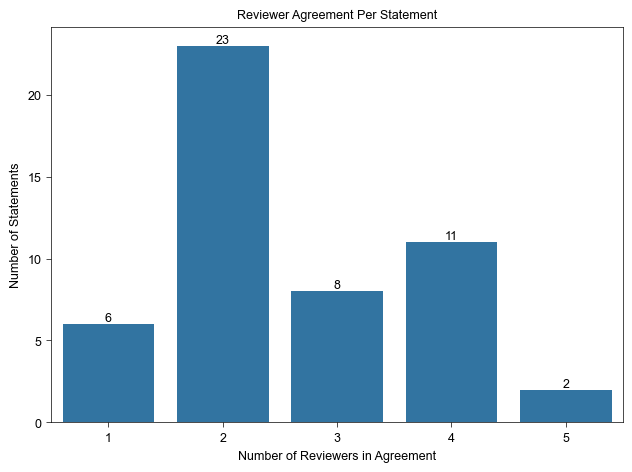

In [13]:
ax = sns.countplot(x="Consensus Count", data=df)
ax.bar_label(ax.containers[0])
apply_luna_theme()
plt.title("Reviewer Agreement Per Statement")
plt.xlabel("Number of Reviewers in Agreement")
plt.ylabel("Number of Statements")
plt.tight_layout()
plt.show()


## ✅ Distribution of 'All Correct' Scores

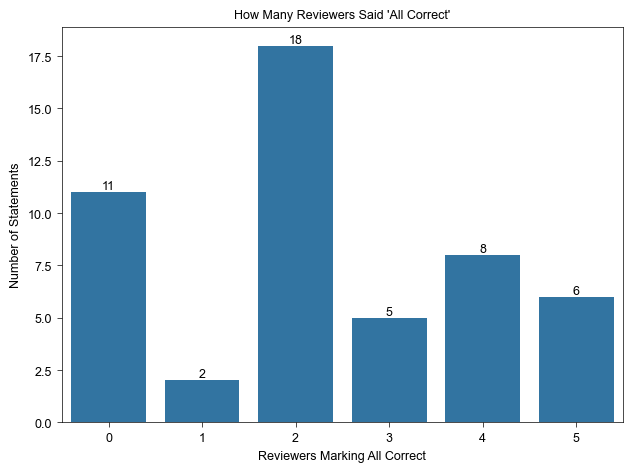

In [14]:
ax = sns.countplot(x="All Correct Count", data=df)
ax.bar_label(ax.containers[0])
apply_luna_theme()
plt.title("How Many Reviewers Said 'All Correct'")
plt.xlabel("Reviewers Marking All Correct")
plt.ylabel("Number of Statements")
plt.tight_layout()
plt.show()


## ❌ Most Common Error Types

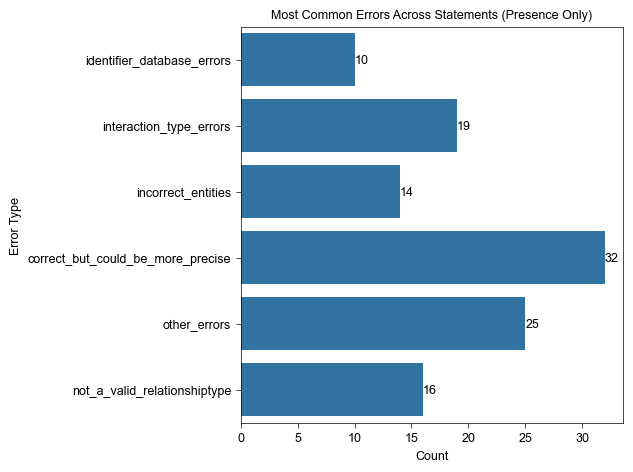

In [15]:
from collections import Counter
import ast

binary_error_counts = Counter()
for val in df["Error Summary"]:
    keys = ast.literal_eval(val).keys()
    binary_error_counts.update(keys)

# Plot
err_df = pd.DataFrame(binary_error_counts.items(), columns=["Error Type", "Count"])
ax = sns.barplot(data=err_df, x="Count", y="Error Type")
ax.bar_label(ax.containers[0])
apply_luna_theme()
plt.title("Most Common Errors Across Statements (Presence Only)")
plt.tight_layout()
plt.show()

## Tagging Easy vs Difficult Statements

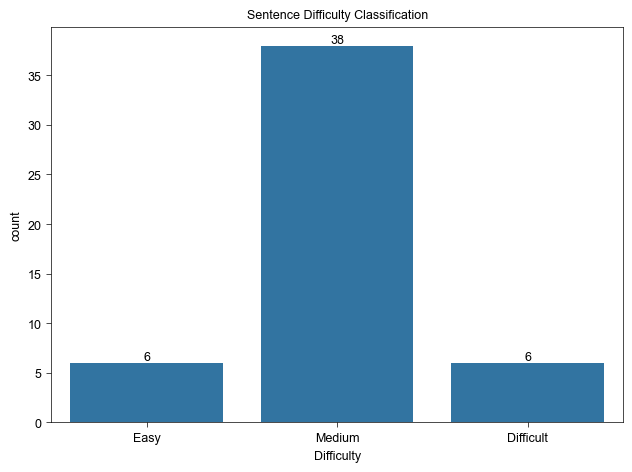

In [16]:
def classify_difficulty(row):
    if row["All Correct Count"] == 5:
        return "Easy"
    elif row["Consensus Count"] < 2:
        return "Difficult"
    else:
        return "Medium"

df["Difficulty"] = df.apply(classify_difficulty, axis=1)
ax = sns.countplot(data=df, x="Difficulty", order=["Easy", "Medium", "Difficult"])
ax.bar_label(ax.containers[0])
apply_luna_theme()
plt.title("Sentence Difficulty Classification")
plt.tight_layout()
plt.show()

In [19]:
from collections import Counter, defaultdict
import ast

# Find difficult statements
difficult_df = df[df["All Correct Count"] == 0]

# Count error types and collect example statements
error_counts = Counter()
error_examples = defaultdict(list)

for _, row in difficult_df.iterrows():
    errors = ast.literal_eval(row["Error Summary"])
    for err in errors:
        error_counts[err] += 1
        if len(error_examples[err]) < 2:  # Show up to 2 examples per error
            error_examples[err].append(row["BEL Statement"])

print("Top error types in difficult statements:")
for err, count in error_counts.most_common(5):
    print(f"\n{err}: {count} statements")
    for example in error_examples[err]:
        print(f"  - Example: {example}")

Top error types in difficult statements:

incorrect_entities: 10 statements
  - Example: a(CHEBI:metformin) hasComponent a(CHEBI:N,N-dimethyl-4-nitrosoaniline)
  - Example: p(HGNC:AKT1) increases p(HGNC:HSF1)

interaction_type_errors: 8 statements
  - Example: a(CHEBI:metformin) hasComponent a(CHEBI:N,N-dimethyl-4-nitrosoaniline)
  - Example: p(HGNC:AKT1) increases p(HGNC:HSF1)

correct_but_could_be_more_precise: 7 statements
  - Example: a(CHEBI:metformin) hasComponent a(CHEBI:N,N-dimethyl-4-nitrosoaniline)
  - Example: p(HGNC:AKT1) increases p(HGNC:HSF1)

other_errors: 7 statements
  - Example: a(CHEBI:metformin) hasComponent a(CHEBI:N,N-dimethyl-4-nitrosoaniline)
  - Example: p(HGNC:AKT1) increases p(HGNC:HSF1)

not_a_valid_relationshiptype: 7 statements
  - Example: a(CHEBI:metformin) hasComponent a(CHEBI:N,N-dimethyl-4-nitrosoaniline)
  - Example: p(HGNC:AKT1) increases p(HGNC:HSF1)


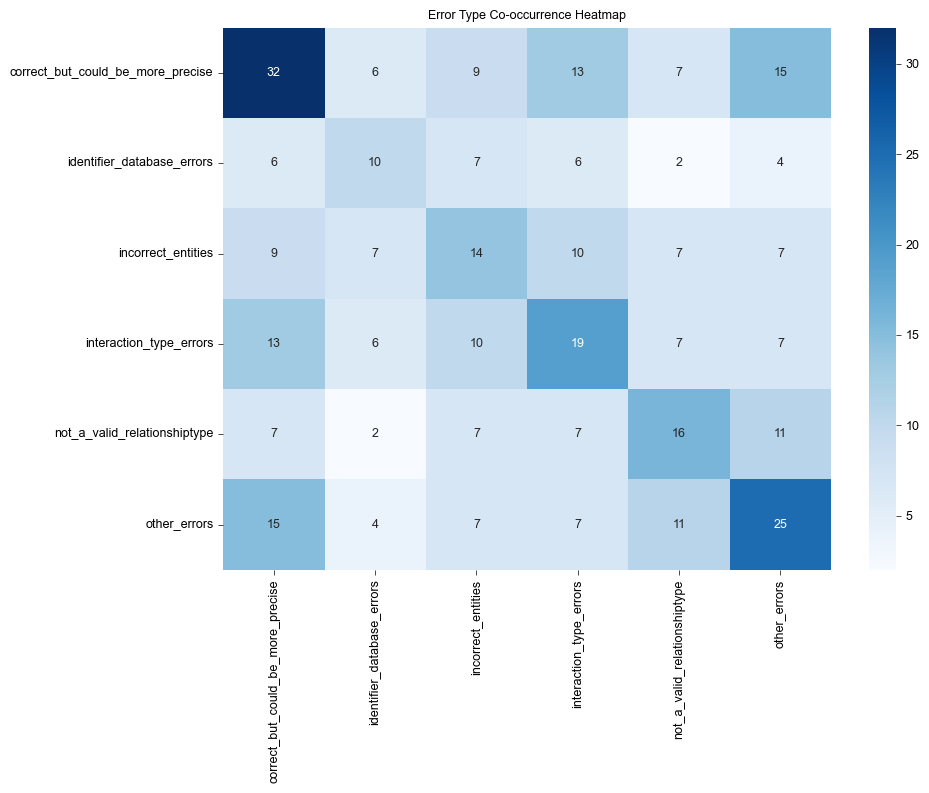

In [17]:
import numpy as np
from collections import defaultdict

# Calculate co-occurrences of error types
error_keys = set()
co_matrix = defaultdict(lambda: defaultdict(int))

for val in df["Error Summary"]:
    err_dict = ast.literal_eval(val)
    keys = list(err_dict.keys())
    for i in range(len(keys)):
        for j in range(len(keys)):
            co_matrix[keys[i]][keys[j]] += 1
            error_keys.add(keys[i])
            error_keys.add(keys[j])

# Convert to matrix
sorted_keys = sorted(error_keys)
matrix = np.zeros((len(sorted_keys), len(sorted_keys)), dtype=int)

for i, key1 in enumerate(sorted_keys):
    for j, key2 in enumerate(sorted_keys):
        matrix[i, j] = co_matrix[key1][key2]

# Create DataFrame for seaborn
co_df = pd.DataFrame(matrix, index=sorted_keys, columns=sorted_keys)

# Plot heatmap
apply_luna_theme()
plt.figure(figsize=(10, 8))
sns.heatmap(co_df, annot=True, fmt="d", cmap="Blues")
plt.title("Error Type Co-occurrence Heatmap")
plt.tight_layout()
plt.show()


In [10]:
total_reviews = len(df) * 5
strict_correct = df["All Correct Count"].sum()
relaxed_correct = 0

# Count relaxed correct scores
for val in df["Error Summary"]:
    score = ast.literal_eval(val)
    count_precise = score.get("correct_but_could_be_more_precise", 0)
    relaxed_correct += count_precise

# Total relaxed = all_correct + correct_but_could_be_more_precise
total_relaxed_correct = strict_correct + relaxed_correct
relaxed_accuracy = total_relaxed_correct / total_reviews

print(f"Strict Accuracy (All Correct only): {strict_correct / total_reviews:.2%}")
print(f"Relaxed Accuracy (Including 'correct_but_could_be_more_precise'): {relaxed_accuracy:.2%}")


Strict Accuracy (All Correct only): 46.00%
Relaxed Accuracy (Including 'correct_but_could_be_more_precise'): 62.80%


In [21]:
# Mean Consensus Score
mean_consensus = df["Consensus Count"].mean()

print(f"Average Reviewer Agreement (Consensus Score): {mean_consensus:.2f} out of 5")

Average Reviewer Agreement (Consensus Score): 2.60 out of 5


In [22]:
fully_precise_count = 0

for _, row in df.iterrows():
    score_dict = ast.literal_eval(row["Error Summary"])
    # If this is the only error key and it appears 5 times
    if score_dict == {"correct_but_could_be_more_precise": 5}:
        fully_precise_count += 1

print(f"Statements where all 5 said 'correct_but_could_be_more_precise': {fully_precise_count}")


Statements where all 5 said 'correct_but_could_be_more_precise': 0


In [9]:
strong_agreement_count = 0
total_statements = len(df)

for _, row in df.iterrows():
    all_correct = row["All Correct Count"]
    summary = ast.literal_eval(row["Error Summary"])
    precise = summary.get("correct_but_could_be_more_precise", 0)
    total_agreed = all_correct + precise

    if total_agreed >= 4:
        strong_agreement_count += 1

percentage = (strong_agreement_count / total_statements) * 100

print(f"Statements where 4 or more reviewers agreed it was correct (all_correct + precise): {strong_agreement_count}")
print(f"Percentage of total statements: {percentage:.2f}%")


Statements where 4 or more reviewers agreed it was correct (all_correct + precise): 20
Percentage of total statements: 40.00%
